version 1.0.1
# ![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# **用Spark做web服务器日志分析**

这里用服务器日志分析为例，给大家展示真实场景中，通常我们是怎么用pySpark去完成大数据的处理和分析的。

Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them.  This homework will show you how to use Apache Spark on real-world text-based production logs and fully harness the power of that data.  Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content,  and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

### 总述
 
#### 这里的应用主要包括4部分：
#### *Part 1*: Apache Web服务器日志格式
#### *Part 2*: web服务器日志初步解析
#### *Part 3*: web服务器日志进一步解析和可视化
#### *Part 4*: 对返回404的结果做分析

### **Part 1: Apache Web服务器日志格式**
这里用到的服务器日志格式是 [Apache Common Log Format (CLF)](http://httpd.apache.org/docs/1.3/logs.html#common)。简单数来，你看到的每一行都是如下的样式：
`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`
 
一个详细一些的字段说明如下：
* `127.0.0.1`<br>
发起请求的客户端IP地址
 
* `-`<br>
The "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.
 
* `-`<br>
The "hyphen" in the output indicates that the requested piece of information (user identity from local logon) is not available.
 
* `[01/Aug/1995:00:00:01 -0400]`<br>
服务器端处理完请求的时间，具体细节如下:<br>
`[day/month/year:hour:minute:second timezone]`
  * day = 2 digits
  * month = 3 letters
  * year = 4 digits
  * hour = 2 digits
  * minute = 2 digits
  * second = 2 digits
  * zone = (\+ | \-) 4 digits
 
* `"GET /images/launch-logo.gif HTTP/1.0"`<br>
客户端请求字符串的第一行，包含3个部分。1）请求方式 (e.g., `GET`, `POST`, 等.), 2）endpoint (a [Uniform Resource Identifier](http://en.wikipedia.org/wiki/Uniform_resource_identifier))，3）客户端协议版本
 
* `200`<br>
服务器发回给客户端的状态码，这个信息非常有用，它告诉我们这个请求成功得到response(以2开头的状态码)，重定向(以3开头的状态码)，客户端引起的错误(以4开头的状态码)，服务器引起的错误(以5开头的状态码)。更多的信息可以查看([RFC 2616](https://www.ietf.org/rfc/rfc2616.txt) section 10).
 
* `1839`<br>
这个数据表明了服务器返回的数据大小（不包括response headers），当然，如果没有返回任何内容，这个值会是"-" (也有时候会是0).

 
### NASA-HTTP Web Server Log
这里的例子用到的是一份来自NASA的服务器日志，完整的数据及可以在[这里](http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) 下载到。

### **解析日志的每一行**
我们写一个python的正则表达式，抽取log中不同部分的信息。然后再对时间字段进行一些解析和处理。

In [2]:
from pyspark import SparkContext
sc = SparkContext('local', 'pyspark')
#sc = SparkContext('spark://ha-nn-001:7077', 'pyspark')

In [3]:
# 用于抽取信息的正则表达式
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [1]:
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

### **初始化RDD并进行相应操作**
下面我们可以用web日志文件初始化一个RDD，然后使用刚才的操作做一个解析了。

In [4]:
import sys
import os

logFile = os.path.join('.', 'NASA_access_log_Aug95')

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline: 895
Invalid logline: 198.213.130.253 - - [03/Aug/1995:11:29:02 -0400] "GET /shuttle/missions/sts-34/mission-sts-34.html"><IMG images/ssbuv1.gif SRC="images/small34p.gif/ HTTP/1.0" 404 -
Invalid logline: ztm-13.dial.xs4all.nl - - [04/Aug/1995:09:34:52 -0400] "GET / /   HTTP/1.0" 200 7034
Invalid logline: pc32.cis.uoguelph.ca - - [04/Aug/1995:10:57:21 -0400] "GET / /   HTTP/1.0" 200 7034
Invalid logline: sgate08.st-and.ac.uk - - [04/Aug/1995:17:52:59 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 6858
Invalid logline: userp2.snowhill.com - - [05/Aug/1995:14:57:06 -0400] "GET / " HTTP/1.0" 200 7034
Invalid logline: ppp-nyc-2-64.ios.com - - [05/Aug/1995:20:45:33 -0400] "GET /shuttle/missions/sts-69/images/images.html 40,207 89,234 HTTP/1.0" 200 2443
Invalid logline: ppp-nyc-2-64.ios.com - - [05/Aug/1995:20:47:52 -0400] "GET /shuttle/countdown/tour.html 40,243 89,262 HTTP/1.0" 200 4347
Invalid logline: client-71-162.online.apple.com - - [05/Aug/1995:22:53:19

### **数据清洗**
刚才解析失败的log不一定是日志本身有问题，也有可能是我们的正则表达式写得不够“全”！

In [5]:
# This was originally '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s?" (\d{3}) (\S+)'

parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline: 782
Invalid logline: 198.213.130.253 - - [03/Aug/1995:11:29:02 -0400] "GET /shuttle/missions/sts-34/mission-sts-34.html"><IMG images/ssbuv1.gif SRC="images/small34p.gif/ HTTP/1.0" 404 -
Invalid logline: ztm-13.dial.xs4all.nl - - [04/Aug/1995:09:34:52 -0400] "GET / /   HTTP/1.0" 200 7034
Invalid logline: pc32.cis.uoguelph.ca - - [04/Aug/1995:10:57:21 -0400] "GET / /   HTTP/1.0" 200 7034
Invalid logline: sgate08.st-and.ac.uk - - [04/Aug/1995:17:52:59 -0400] "GET /htbin/wais.pl?Wake Shield HTTP/1.0" 200 6858
Invalid logline: userp2.snowhill.com - - [05/Aug/1995:14:57:06 -0400] "GET / " HTTP/1.0" 200 7034
Invalid logline: ppp-nyc-2-64.ios.com - - [05/Aug/1995:20:45:33 -0400] "GET /shuttle/missions/sts-69/images/images.html 40,207 89,234 HTTP/1.0" 200 2443
Invalid logline: ppp-nyc-2-64.ios.com - - [05/Aug/1995:20:47:52 -0400] "GET /shuttle/countdown/tour.html 40,243 89,262 HTTP/1.0" 200 4347
Invalid logline: client-71-162.online.apple.com - - [05/Aug/1995:22:53:19

### **Part 2: web服务器日志初步解析**
 
所以我们现在已经有了一个包含日志的RDD，我们可以进行一系列的分析了。
 
#### **返回内容大小分析**
 
我们先对web日志返回的结果做一点小小的统计，求出来最大和最小的返回内容大小。

In [6]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())

Content Size Avg: 17097, Min: 0, Max: 3421948


#### **返回状态码分析**
接着我们对返回的状态码做一个计数分析，看看502之类的结果有多少个。

In [7]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList
assert len(responseCodeToCountList) == 7
assert sorted(responseCodeToCountList) == [(200, 1398317), (302, 26440), (304, 134138), (403, 171), (404, 10020), (500, 3), (501, 27)]

Found 7 response codes
Response Code Counts: [(200, 1398317), (500, 3), (501, 27), (302, 26440), (403, 171), (304, 134138), (404, 10020)]


#### **用 `matplotlib`对统计结果做可视化**

In [8]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[200, 500, 501, 302, 403, 304, 404]
[0.891149538976086, 1.911904537331848e-06, 1.720714083598663e-05, 0.01685025198901802, 0.00010897855862791534, 0.08548635027620648, 0.006385761154688373]


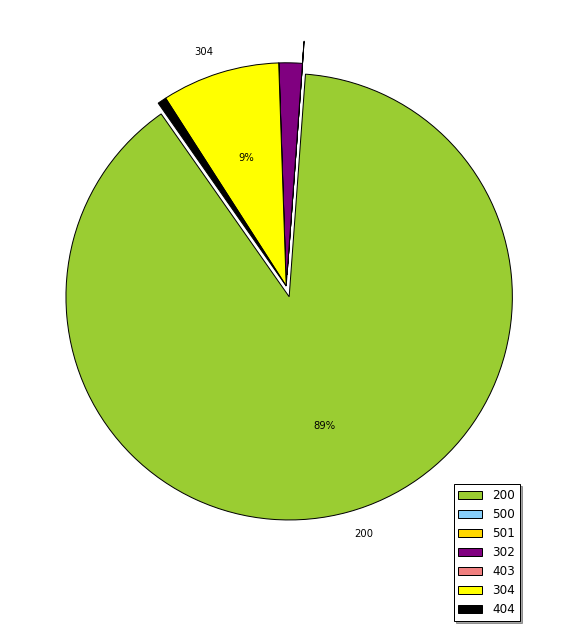

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(10, 10), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

#### **频度最高的Host**
我们来统计一下发起请求的客户端host频度，并找出频度最高的host

In [10]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20
# An example: [u'204.120.34.185', u'204.243.249.9', u'slip1-32.acs.ohio-state.edu', u'lapdog-14.baylor.edu', u'199.77.67.3', u'gs1.cs.ttu.edu', u'haskell.limbex.com', u'alfred.uib.no', u'146.129.66.31', u'manaus.bologna.maraut.it', u'dialup98-110.swipnet.se', u'slip-ppp02.feldspar.com', u'ad03-053.compuserve.com', u'srawlin.opsys.nwa.com', u'199.202.200.52', u'ix-den7-23.ix.netcom.com', u'151.99.247.114', u'w20-575-104.mit.edu', u'205.25.227.20', u'ns.rmc.com']

Any 20 hosts that have accessed more then 10 times: [u'slip214.basenet.net', u'dialup92.azstarnet.com', u'ix-dc9-20.ix.netcom.com', u'205.229.106.37', u'204.189.43.4', u'202.40.17.51', u'199.2.42.70', u'169.140.8.195', u'mac24.univ-relations.pitt.edu', u'salud.gsfc.nasa.gov', u'ndts3.pt03.ndsu.nodak.edu', u'van08223.direct.ca', u'ix-mvo-ca4-17.ix.netcom.com', u'slip214.hk.super.net', u'jbalboni.arc.nasa.gov', u'cafe07.babel.dk', u'bombgmt.hip.cam.org', u'remote119.arc.ab.ca', u'194.166.27.5', u'147.150.5.96']


#### **可视化Endpoints**
lets visualize the number of hits to endpoints (URIs) in the log

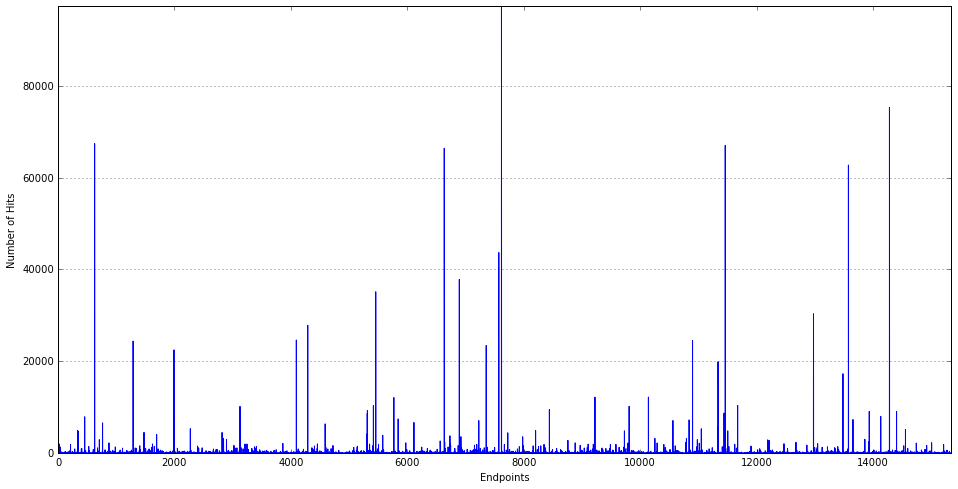

In [22]:
%matplotlib inline
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = plt.figure(figsize=(16,8), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
pass

#### **最高频的Endpoints**

In [12]:
# Top Endpoints
endpointCounts = (access_logs
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print 'Top Ten Endpoints: %s' % topEndpoints

Top Ten Endpoints: [(u'/images/NASA-logosmall.gif', 59737), (u'/images/KSC-logosmall.gif', 50452), (u'/images/MOSAIC-logosmall.gif', 43890), (u'/images/USA-logosmall.gif', 43664), (u'/images/WORLD-logosmall.gif', 43277), (u'/images/ksclogo-medium.gif', 41336), (u'/ksc.html', 28582), (u'/history/apollo/images/apollo-logo1.gif', 26778), (u'/images/launch-logo.gif', 24755), (u'/', 20292)]


### **Part 3: web服务器日志进一步解析和可视化**
 
我们再来做一些进一步的日志分析和可视化

#### **最高频的正确响应和错误响应Endpoints**
我们来找一找最高频的返回错误的Endpoints(返回状态码200 和 非200)

In [23]:
not200 = access_logs.filter(lambda log: log.response_code != 200)

endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda a, b : a + b)

topTenURLs = endpointSum.takeOrdered(10, lambda s: -1 * s[1])
print 'Top Ten failed URLs: %s' % topTenURLs

Top Ten failed URLs: [(u'/images/NASA-logosmall.gif', 19072), (u'/images/KSC-logosmall.gif', 11328), (u'/images/MOSAIC-logosmall.gif', 8617), (u'/images/USA-logosmall.gif', 8565), (u'/images/WORLD-logosmall.gif', 8360), (u'/images/ksclogo-medium.gif', 7722), (u'/history/apollo/images/apollo-logo1.gif', 4355), (u'/shuttle/countdown/images/countclock.gif', 4227), (u'/images/launch-logo.gif', 4178), (u'/', 3605)]


#### **不同的Host个数统计**

In [25]:
hosts = access_logs.map(lambda log: (log.host, 1))

uniqueHosts = hosts.reduceByKey(lambda a, b : a + b)

uniqueHostCount = uniqueHosts.count()
print 'Unique hosts: %d' % uniqueHostCount

Unique hosts: 75050


#### **每一天有多少不同的Host**

In [ ]:
dayToHostPairTuple = access_logs.map(lambda log: (log.date_time.day, log.host))

dayGroupedHosts = dayToHostPairTuple.combineByKey(lambda v: [v], lambda c, v: c + [v], lambda c1, c2: c1 + c2)

dayHostCount = dayGroupedHosts.map(lambda (k, v): (k, len(set(v))))
                                                   
dailyHosts = dayHostCount.sortByKey(ascending=True).cache()

dailyHostsList = dailyHosts.take(30)
print 'Unique hosts per day: %s' % dailyHostsList

#### **对每一天不同的host个数做可视化**

In [19]:
daysWithHosts = dailyHosts.map(lambda (x, y): x).collect()
hosts = dailyHosts.map(lambda (x, y): y).collect()

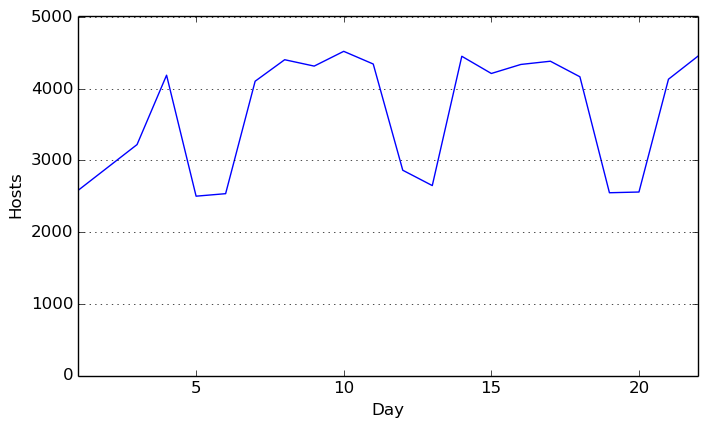

In [21]:
fig = plt.figure(figsize=(8,4.5), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.plot(daysWithHosts, hosts)
pass

#### **统计每一天单个Host平均发起的请求数**
我们返回一个list，里面每个元素是(一个月中第几天，发起请求的平均值)样式

In [22]:
dayAndHostTuple = access_logs.map(lambda log: (log.date_time.day, log.host))

groupedByDay = dayAndHostTuple.combineByKey(lambda v: [v], lambda c, v: c + [v], lambda c1, c2: c1 + c2)

sortedByDay = groupedByDay.sortByKey(ascending=True)

avgDailyReqPerHost = sortedByDay.map(lambda (k, v): (k, len(v) / len(set(v)))).cache()

avgDailyReqPerHostList = avgDailyReqPerHost.take(30)
print 'Average number of daily requests per Hosts is %s' % avgDailyReqPerHostList

Average number of daily requests per Hosts is [(1, 13), (3, 12), (4, 14), (5, 12), (6, 12), (7, 13), (8, 13), (9, 14), (10, 13), (11, 14), (12, 13), (13, 13), (14, 13), (15, 13), (16, 13), (17, 13), (18, 13), (19, 12), (20, 12), (21, 13), (22, 12)]


#### **可视化每一天单个Host平均发起的请求数**

In [24]:
daysWithAvg = avgDailyReqPerHost.map(lambda (x, y): x).collect()
avgs = avgDailyReqPerHost.map(lambda (x, y): y).collect()

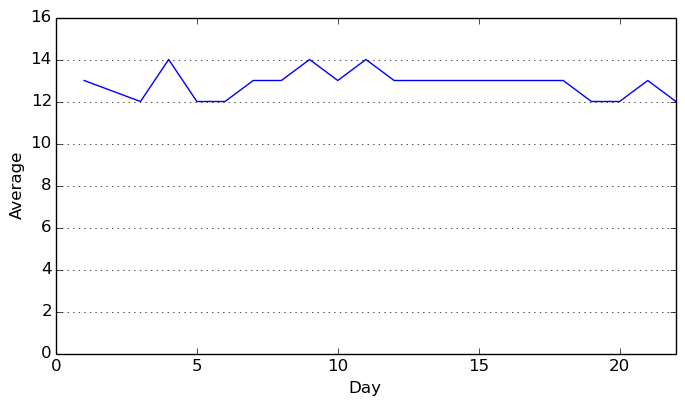

In [26]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)
pass

### **Part 4: 对返回404的结果做分析**

日志里到底有多少条返回404的记录？

In [27]:
badRecords = (access_logs
              .filter(lambda log: log.response_code == 404)
              .cache())
print 'Found %d 404 URLs' % badRecords.count()

Found 6185 404 URLs


#### **抽取返回404的记录Endpoint并输出**

In [29]:
badEndpoints = badRecords.map(lambda log: log.endpoint)

badUniqueEndpoints = badEndpoints.distinct()

badUniqueEndpointsPick40 = badUniqueEndpoints.take(40)
print '404 URLS: %s' % badUniqueEndpointsPick40

404 URLS: [u'/11/history/apollo/images/', u'/128.159.104.89/tv/tv.html', u'/imag', u'/shuttle/missionssts-70/woodpecker.html', u'/~terrig/bookmark.html', u'/elv/ATLAS_CENTAUR/p-ae.gif', u'/pub.win', u'/ksc.nasa.gov/images/ksclogo-medium.gif', u'/history/apollo-13', u'/shuttle/missioins/sts-70/movies/', u'/shuttle/missions/sts-69/mission-sts-74.html', u'/shuttle/missions/sts-80/mission-sts-80.html', u'/histort/apollo/apollo13', u'/www/ksc', u'/shuttle/miccions/sts-73/mission-sts-73.html', u'/images/lf.gif', u'/shuttle/Missions/missions.html', u'/ksc', u'/shuttle/missions/mission.html/', u'/images/jpeg/', u'/shuttle/missions/sts-71/sts-69-info.html', u'/images/crawlerway-logo.gif', u'/home/whats-cool.html', u'/procurement/business/ciao1.htm', u'/icons/blank', u'/HISTORY/APOLLO/', u'/finance/main.html', u'/history/apollo/apollo-13/apollo_13.html', u'/shuttle/countdown/images/yforw.gif', u'/intersex.com/crawler.gif', u'/history/apollo-13-info.html', u'/images/hq.jpeg', u'/history/apollo/ap

#### **从返回404的Endpoints里找出频度最高的20个**

In [31]:
badEndpointsCountPairTuple = badRecords.map(lambda log: (log.endpoint, 1))

badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(lambda a, b: a + b)

badEndpointsTop20 = badEndpointsSum.takeOrdered(20, lambda s: -1 * s[1])
print 'Top Twenty 404 URLs: %s' % badEndpointsTop20

Top Twenty 404 URLs: [(u'/pub/winvn/readme.txt', 633), (u'/pub/winvn/release.txt', 494), (u'/shuttle/missions/STS-69/mission-STS-69.html', 431), (u'/images/nasa-logo.gif', 319), (u'/elv/DELTA/uncons.htm', 178), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 156), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 146), (u'/images/crawlerway-logo.gif', 120), (u'/://spacelink.msfc.nasa.gov', 117), (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 100), (u'/history/apollo/a-001/a-001-patch-small.gif', 97), (u'/images/Nasa-logo.gif', 85), (u'/shuttle/resources/orbiters/atlantis.gif', 64), (u'/history/apollo/images/little-joe.jpg', 62), (u'/images/lf-logo.gif', 59), (u'/shuttle/resources/orbiters/discovery.gif', 56), (u'/shuttle/resources/orbiters/challenger.gif', 54), (u'/robots.txt', 53), (u'/elv/new01.gif>', 43), (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 38)]


#### **找出前25个返回404的host**

In [33]:
errHostsCountPairTuple = badRecords.map(lambda log: (log.host, 1))

errHostsSum = errHostsCountPairTuple.reduceByKey(lambda a, b: a + b)

errHostsTop25 = errHostsSum.takeOrdered(25, lambda s: -1 * s[1])
print 'Top 25 hosts that generated errors: %s' % errHostsTop25

Top 25 hosts that generated errors: [(u'piweba3y.prodigy.com', 39), (u'maz3.maz.net', 39), (u'gate.barr.com', 38), (u'm38-370-9.mit.edu', 37), (u'ts8-1.westwood.ts.ucla.edu', 37), (u'nexus.mlckew.edu.au', 37), (u'204.62.245.32', 33), (u'spica.sci.isas.ac.jp', 27), (u'163.206.104.34', 27), (u'www-d4.proxy.aol.com', 26), (u'203.13.168.24', 25), (u'www-c4.proxy.aol.com', 25), (u'203.13.168.17', 25), (u'internet-gw.watson.ibm.com', 24), (u'crl5.crl.com', 23), (u'scooter.pa-x.dec.com', 23), (u'piweba5y.prodigy.com', 23), (u'onramp2-9.onr.com', 22), (u'slip145-189.ut.nl.ibm.net', 22), (u'198.40.25.102.sap2.artic.edu', 21), (u'gn2.getnet.com', 20), (u'msp1-16.nas.mr.net', 20), (u'dial055.mbnet.mb.ca', 19), (u'isou24.vilspa.esa.es', 19), (u'tigger.nashscene.com', 19)]


#### **统计每一天返回404的记录条数**

In [35]:
errDateCountPairTuple = badRecords.map(lambda log: (log.date_time.day, 1))

errDateSum = errDateCountPairTuple.reduceByKey(lambda a, b: a + b)

errDateSorted = (errDateSum
                 .sortByKey(ascending=True)
                 .cache())

errByDate = errDateSorted.collect()
print '404 Errors by day: %s' % errByDate

404 Errors by day: [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), (8, 381), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 326), (16, 258), (17, 269), (18, 255), (19, 207), (20, 312), (21, 305), (22, 288)]


#### **对每一天返回404记录的条数做可视化**

In [37]:
daysWithErrors404 = errDateSorted.map(lambda (x, y): x).collect()
errors404ByDay = errDateSorted.map(lambda (x, y): y).collect()

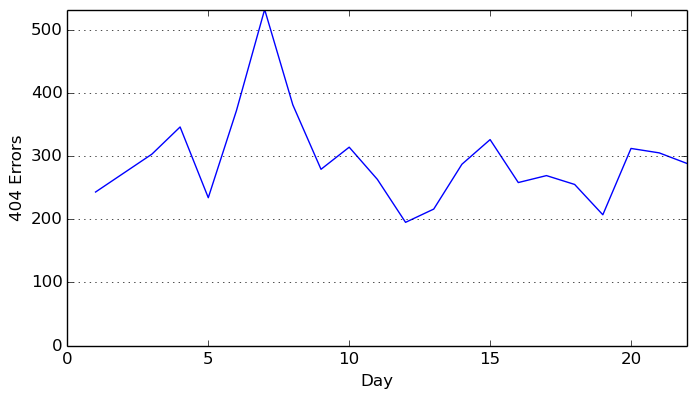

In [39]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)
pass

#### **返回404最多的5天 **

In [40]:
topErrDate = errDateSorted.takeOrdered(5, lambda s: -1 * s[1])
print 'Top Five dates for 404 requests: %s' % topErrDate

Top Five dates for 404 requests: [(7, 532), (8, 381), (6, 372), (4, 346), (15, 326)]


#### **按小时分析返回404的请求数**

In [42]:
hourCountPairTuple = badRecords.map(lambda log: (log.date_time.hour, 1))

hourRecordsSum = hourCountPairTuple.reduceByKey(lambda a, b: a + b)

hourRecordsSorted = (hourRecordsSum
                     .sortByKey(ascending=True)
                     .cache())

errHourList = hourRecordsSorted.collect()
print 'Top hours for 404 requests: %s' % errHourList

Top hours for 404 requests: [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93), (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), (21, 241), (22, 234), (23, 272)]


#### **统计按小时返回404的记录条数**

In [44]:
hoursWithErrors404 = hourRecordsSorted.map(lambda (x, y): x).collect()
errors404ByHours = hourRecordsSorted.map(lambda (x, y): y).collect()

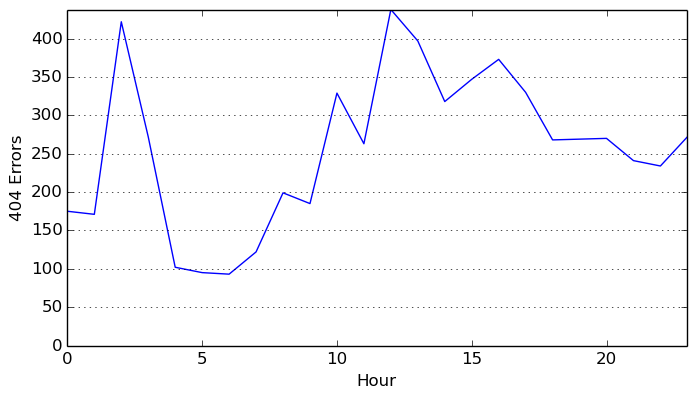

In [46]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
pass